# Homework 3

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import os

# Part 1: Email spam classification [30 points]

   - Get the data from: http://www.andrew.cmu.edu/user/georgech/preprocessed-enron-email-dataset.zip
   - Unzip this into the same folder as this notebook, rename it to `email-data`
   - The folder contains 3 subfolders:
      - `ham` contains ham emails.
      - `spam` contains spam emails.
      - `testing` is a folder containing test emails for your classifier. The ham/spam label is in the filename.
      
**Important**: For this problem, do *not* use neural nets/deep nets.

**(a) Print the number of ham and spam emails [1 point]**

In addition to providing the code, respond to the following questions:

   - Is this dataset imbalanced? Will this be problematic in training the model?
   - If so, how would you address it? (You do *not* have to implement what you suggest here for later parts of the problem.)

In [2]:
#your code here
from glob import glob
spam_count = len(glob('./email-data/spam/*.txt'))
ham_count = len(glob('./email-data/ham/*.txt'))
print(spam_count)
print(ham_count)

3671
1500


**Your answers to the above questions:** While there's class imbalance (there are a lot more spam than ham examples), the class imbalance is not extreme (e.g., where one class takes up 99% of the total number of examples). To deal with this class imbalance, many methods are possible. For example, stratified k-fold cross-validation can preserve the class proportions per fold (stratified k-fold cross-validation just enforces that the same proportion of each class is sampled per fold as the overall training data). Again, since the class imbalance is actually not that extreme, this sort of precaution isn't actually necessary. Note that if instead the class imbalance were extreme, a strategy like stratified k-fold cross-validation could be essential to ensure that enough minority class examples actually show up in each fold.

There are many other methods possible as well, with the basic idea of either undersampling a class with too many examples (for example, just randomly sampling from the majority class so that it's the same size as the minority class), or oversampling a class with too few examples (a naive approach would be to just duplicate some randomly chosen minority examples to increase the minority class size; fancier approaches are possible that try to generate synthetic examples based on interpolating between real examples). For a whole library of functions for dealing with imbalanced data, see: https://imbalanced-learn.org/stable/index.html

**(b) Construct the documents [4 points]**
 
   - Provided below is a function that returns a document present in a file given a fileName.
   - The function performs some preprocessing to (1) remove punctuation, (2),(3) remove whitespace and (4) lowercase all words.
   - Use this function to construct a list of documents.
   - Also construct a list of document labels containing `1` for spam and `0` for ham.

In [3]:
import re
import string
import codecs

def makeWordList(path):
    
    with codecs.open(path, "r", encoding='utf-8', errors='ignore') as f:
        corpus_text = f.read()

    for c in string.punctuation:
        corpus_text = corpus_text.replace(c, "")  # -- (1)
    
    text = re.sub(r'\S*\d\S*','',corpus_text) # -- (2)
    text = re.sub(r'[^\w\s]','',text)         # -- (3)
    
    text = text.lower().split()           # -- (4)         
    
    li = []
    for token in text:
        li.append(token)

    return " ".join(li)

In [4]:
#your code here
documents = [makeWordList(filename) for filename in glob('./email-data/spam/*.txt')] \
    + [makeWordList(filename) for filename in glob('./email-data/ham/*.txt')]
labels = np.concatenate((np.ones(spam_count), np.zeros(ham_count)))
print(len(documents))

5171


**(c) Construct the document matrix `X` as a matrix of word frequencies [5 points]**

   - Use the `CountVectorizer` from scikit-learn.
   - Set `min_df=50`; this drops words that don't occur in at least 50 documents.
   - Set `stop_words="english"` and `max_df=0.8` to filter out stop-words.
   - Print the size of the vocabulary (number of unique words)

In [5]:
#your code here
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(min_df=50, max_df=0.8, stop_words="english")
X = vectorizer.fit_transform(documents)
print(len(vectorizer.vocabulary_))

1680


**(d) k-NN and random forest: Hyperparameter selection [10 points]**

Now that you have your documents and labels as training data, you can perform 5-fold cross-validation to select the hyperparameters for different learning algorithms.

The hyperparameter with the best performance averaged across 5 folds is chosen. Use the **weighted F1-score** as the evaluation metric (i.e., for the `f1_score` function imported from `sklearn.metrics`, be sure to use the parameter `average='weighted'`).

   - k-NN: Select `k` from a range of values of your choice.
   - Random forest: Select `max_features` **and** `min_samples_leaf` from a grid of your choice.

Store each chosen hyperparameter as `best_k`, `best_max_features`, and `best_min_samples_leaf` respectively.

Provided is some seed code for cross-validation that you may modify and reuse. Do not use the cross-validations score or grid-search functions from scikit-learn (you may use `KFold`).

In [6]:
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score

num_folds = 5
k_fold = KFold(num_folds, shuffle=True, random_state=0)
hyperparameter_settings = np.arange(1, 6)

best_hyperparam_setting = None
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    k = hyperparam_setting
    for proper_train_indices, val_indices in k_fold.split(X, labels):
        proper_train_features = X[proper_train_indices]
        proper_train_labels = labels[proper_train_indices]
        val_features = X[val_indices]
        val_labels = labels[val_indices]
        
        clf = KNeighborsClassifier(n_neighbors=k)
        clf.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = clf.predict(val_features)
        fold_scores.append(f1_score(val_labels, predicted_val_labels,
                                    average='weighted'))
    
    cross_val_score = np.mean(fold_scores)
    print(hyperparam_setting, ':', cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)
best_k = best_hyperparam_setting

1 : 0.9369646862749883
2 : 0.9337350526159673
3 : 0.91398157387451
4 : 0.9328559341967946
5 : 0.9115445180580579
Best hyperparameter setting: 1


In [7]:
from sklearn.ensemble import RandomForestClassifier

k_fold = KFold(num_folds, shuffle=True, random_state=0)
num_features = X.shape[1]
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.sqrt(num_features) / 4),
                                                int(np.sqrt(num_features) / 2),
                                                int(np.sqrt(num_features)),
                                                int(np.sqrt(num_features) * 2),
                                                int(np.sqrt(num_features) * 4)]
                           for min_samples_leaf in [1, 2, 4, 8, 16, 32, 64]]
best_cross_val_score = -np.inf  # assumes that a higher score is better
for hyperparam_setting in hyperparameter_settings:
    fold_scores = []
    # your code to train and score the training data here
    max_features, min_samples_leaf = hyperparam_setting
    for proper_train_indices, val_indices in k_fold.split(X, labels):
        proper_train_features = X[proper_train_indices]
        proper_train_labels = labels[proper_train_indices]
        val_features = X[val_indices]
        val_labels = labels[val_indices]
        
        clf = RandomForestClassifier(max_features=max_features,
                                     min_samples_leaf=min_samples_leaf,
                                     random_state=0)
        clf.fit(proper_train_features, proper_train_labels)
        predicted_val_labels = clf.predict(val_features)
        fold_scores.append(f1_score(val_labels, predicted_val_labels,
                                    average='weighted'))
    
    cross_val_score = np.mean(fold_scores)
    print(hyperparam_setting, ':', cross_val_score)
    if cross_val_score > best_cross_val_score:  # assumes that a higher score is better
        best_cross_val_score = cross_val_score
        best_hyperparam_setting = hyperparam_setting

print('Best hyperparameter setting:', best_hyperparam_setting)
best_max_features, best_min_samples_leaf = best_hyperparam_setting

(10, 1) : 0.9906762546227655
(10, 2) : 0.9820347666672257
(10, 4) : 0.9733230807301012
(10, 8) : 0.9506780975645059
(10, 16) : 0.9176062058248908
(10, 32) : 0.8632045664508929
(10, 64) : 0.7421763494998922
(20, 1) : 0.9893261675476186
(20, 2) : 0.9844100171854444
(20, 4) : 0.9784841834828623
(20, 8) : 0.9683120894424537
(20, 16) : 0.9469565992240018
(20, 32) : 0.9102053337811938
(20, 64) : 0.8235920170274641
(40, 1) : 0.9881794673416229
(40, 2) : 0.983847259441198
(40, 4) : 0.979498596286672
(40, 8) : 0.9739369604429738
(40, 16) : 0.9613279578147965
(40, 32) : 0.9407961223715006
(40, 64) : 0.8840070791375547
(81, 1) : 0.9844980357624303
(81, 2) : 0.981728024032104
(81, 4) : 0.9775983804996912
(81, 8) : 0.9734112834525123
(81, 16) : 0.9650168036611113
(81, 32) : 0.9515745640741858
(81, 64) : 0.9234150970369169
(163, 1) : 0.9798585850446448
(163, 2) : 0.9795985739977058
(163, 4) : 0.9738719612186502
(163, 8) : 0.967370021348937
(163, 16) : 0.9623698382804158
(163, 32) : 0.950868534326918

**(e) Classifier testing: Precision-Recall and ROC curves [10 points]**

   - Use the best hyperparameters for each classifier from the previous question to **train** your classifiers on the full training data.
   - Use test emails in the `testing` folder to **test** your classifiers and construct the plots below.

Things to plot:

   - Construct one plot containing 2 ROC curves, one for each classifier. (We vary the threshold probability of declaring an email to be spam to obtain these plots.)
   - In the legend of this plot, display the AUC for each classifier.
   - Construct one plot containing 2 precision-recall curves, one for each classifier.
   - In the legend of each plot, display the average precision for each classifier using the sklearn function [`average_precision_score`](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.average_precision_score.html#sklearn.metrics.average_precision_score); average precision is essentially an approximation of the area under the precision-recall curve that avoids being overly optimistic.

Note that these plots are on the test data: you will have to read in this data, construct a document matrix and labels. Some words in the test data may not have been present in the training data: there are multiple ways to address this, briefly describe your approach.

Things to answer:

   - Of the ROC and Precision-Recall curves, which one would you use for this task and why?
   - Which classifier is the best, according to your chosen curves?

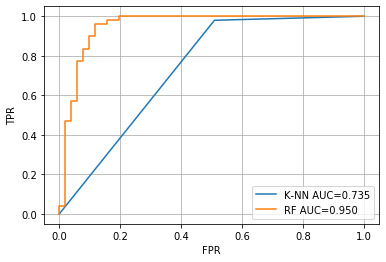

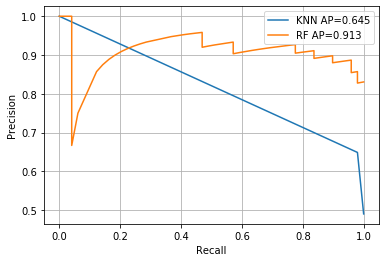

In [8]:
#your code here

# Step 1. Train classifiers using best hyperparameter choices
clf_knn = KNeighborsClassifier(n_neighbors=best_k)
clf_rf = RandomForestClassifier(max_features=best_max_features,
                                min_samples_leaf=best_min_samples_leaf,
                                random_state=0)
clf_knn.fit(X, labels)
clf_rf.fit(X, labels)

# Step 2. Load test data
test_files = glob('./email-data/testing/*.txt')

test_documents = []
test_labels = []
for file in test_files:
    test_documents.append(makeWordList(file))
    if file.find("ham") != -1:
        test_labels.append(0)
    else:
        test_labels.append(1)

test_features = vectorizer.transform(test_documents)

# Step 3. Predict on test data
predicted_test_labels_knn = clf_knn.predict_proba(test_features)[:,1]
predicted_test_labels_rf = clf_rf.predict_proba(test_features)[:,1]

# Step 4. Plot ROC curves

from sklearn.metrics import roc_curve

plt.figure()

fpr, tpr, _ = roc_curve(test_labels, predicted_test_labels_knn, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="K-NN AUC=" + "{:.3f}".format(auc))

fpr, tpr, _ = roc_curve(test_labels, predicted_test_labels_rf, pos_label=1)
auc = np.trapz(tpr, fpr)
plt.plot(fpr, tpr, label="RF AUC=" + "{:.3f}".format(auc))

plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.legend()
plt.show()

# Step 5. Plot precision-recall curves

from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure()

p, r, _ = precision_recall_curve(test_labels, predicted_test_labels_knn, pos_label=1)
ap = average_precision_score(test_labels, predicted_test_labels_knn)
plt.plot(r, p, label="KNN AP=" + "{:.3f}".format(ap))

p, r, _ = precision_recall_curve(test_labels, predicted_test_labels_rf, pos_label=1)
ap = average_precision_score(test_labels, predicted_test_labels_rf)
plt.plot(r, p, label="RF AP=" + "{:.3f}".format(ap))

plt.xlabel("Recall")
plt.ylabel("Precision")
plt.grid()
plt.legend()
plt.show()

**Your answers to the above questions:** For email spam detection in particular, actually either an ROC curve or a precision-recall curve is fine. The main thing here to think about is what the user experience is and what the cost to a user is of an error in classification. Most people probably don't check their spam box that often, so it would be great if an extremely important ham email doesn't end up being predicted as spam --- this would be a false positive. However, people do frequently check the inbox (which consists of items predicted as ham), and if there's spam there, the cost to the user is actually not all that high--the user just flags a spam email in the inbox as "spam" and moves on with life. In particular, email spam detection is not a high-stakes problem (usually).

The errors we want to minimize are false positives. An ROC curve let's us directly see the false positive rate; we can ask for this to be some desired level (close to 0) and then look for a classifier that has as high of a true positive rate as possible. However, precision in this case could also be used for the following reason: every single predicted spam email gets put into the spam box; we want as close to 0 of these to be ham, which precisely corresponds to the precision being as close to 100% as possible. Errors showing up within the items predicted to be ham and thus placed in the inbox are less of a concern. Thus, alternatively we could ask for the precision to be some desired level (close to 100%) and then look for a classifier that has as high of a recall (which is the same as true positive rate) as possible.

# Part 2: Representation Learning [40 points]

Before getting started, please put the attached file `pretrained_convnet.pt` in the same directory as this notebook.

Recall from lecture the "crumpled paper analogy": in a neural net, as you progress through the layers from input to output, the layers should be "unfolding the original space" to disentangle the classes. When you get to the layer before the classifier, you should've changed the data representation into something that makes classification easy. **We will refer to the layer before the classifier in the neural net as the bottleneck layer.**

In this problem, you will be using an output of a bottleneck layer from pre-trained CNN as input features for a few simple classifiers. The CNN provided was trained with the Fashion MNIST dataset which consists of 10 classes of 28x28 grayscale images; this dataset is very similar to MNIST in that there are 10 classes with images that are the same size as MNIST and in fact even the training and test set sizes are the same (60,000 and 10,000 respectively). However, the classes are not the digits 0 through 9. Instead the classes are:

| Class | Description |
| ----- | :---------: |
| 0     | T-shirt/top |
| 1     | Trouser     |
| 2     | Pullover    |
| 3     | Dress       |
| 4     | Coat        |
| 5     | Sandal      |
| 6     | Shirt       |
| 7     | Sneaker     |
| 8     | Bag         |
| 9     | Ankle boot  |

Let's start with some imports.

In [9]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchsummaryX import summary

from UDA_pytorch_utils import UDA_pytorch_model_transform

**Loading in the data.** We first load the Fashion MNIST dataset and plot some example images.

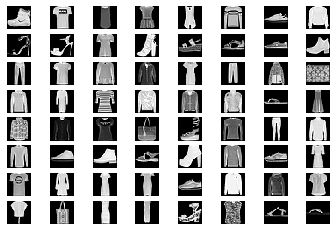

In [10]:
# do not modify this cell
train_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                  train=True,
                                                  transform=transforms.ToTensor(),
                                                  download=True)

train_images = torch.tensor([image.numpy() for image, label in train_dataset])
train_labels = torch.tensor([label for image, label in train_dataset])

test_dataset = torchvision.datasets.FashionMNIST(root='data/',
                                                 train=False,
                                                 transform=transforms.ToTensor(),
                                                 download=True)

test_images = torch.tensor([image.numpy() for image, label in test_dataset])
test_labels = torch.tensor([label for image, label in test_dataset])

# show some of the first training images
square_grid_num_rows = 8
num_images_to_show = square_grid_num_rows ** 2
for idx in range(num_images_to_show):
    plt.subplot(square_grid_num_rows, square_grid_num_rows, idx + 1)
    plt.imshow(train_images[idx][0], cmap='gray')
    plt.axis('off')

**(a) [5 points]** Select train and test data that belong to classes 2 (corresponding to pullovers) or 6 (corresponding to fancier shirts than t-shirts; note: class 0 corresponds to t-shirts), i.e., subsample all the data that has label 2 or 6. Save the variables as `x_train`, `x_test`, `y_train`, `y_test`. From now on, we are only dealing with the images that are in classes 2 (pullovers) or 6 (shirts). Moreover, in `y_train` and `y_test`, please renumber the two classes so that pullovers now instead corresponds to 0 and shirts corresponds to 1 (we will consider shirts to be the "positive" class and pullovers to be the "negative" class).

In [11]:
# write your code here
mask = (train_labels == 2) | (train_labels == 6)
x_train = train_images[mask]
y_train = 1*(train_labels[mask] == 6)

mask = (test_labels == 2) | (test_labels == 6)
x_test = test_images[mask]
y_test = 1*(test_labels[mask] == 6)

In [12]:
# do not modify this cell
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

torch.Size([12000, 1, 28, 28]) torch.Size([12000])
torch.Size([2000, 1, 28, 28]) torch.Size([2000])


We will make some t-SNE visualizations shortly and using all the training data will be too slow. We reduce the size of the training dataset by randomly subsampling 1000 samples from `x_train`/`y_train` pairs and saving the subsampled versions as `x_train_small`/`y_train_small` (the i-th image in `x_train_small` should have its label given by the i-th entry in `y_train_small`). We have provided the indices of which 1000 samples to use (from within `x_train`/`y_train`).

In [13]:
# do not modify this cell
np.random.seed(0)
random_sample = np.random.permutation(len(x_train))[:1000]

In [14]:
# write your code here
x_train_small = x_train[random_sample]
y_train_small = y_train[random_sample]

**(b) [9 points]** We are ready to load the pre-trained convnet. The bottleneck layer is right before the final linear layer and corresponds to the output of a ReLU that has 84 values. **We refer to the output of this ReLU as the bottleneck feature vector representation of whatever the input is.**

Note that the convnet was pre-trained using the entire training dataset which consists of 60,000 samples and all 10 labels.

In [15]:
# load the pre-trained CNN
convnet = nn.Sequential(nn.Conv2d(1, 6, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Conv2d(6, 16, 3),
                        nn.ReLU(),
                        nn.MaxPool2d(2),
                        nn.Flatten(),
                        nn.Linear(in_features=16 * 5 * 5, out_features=120),
                        nn.ReLU(),
                        nn.Linear(in_features=120, out_features=84),
                        nn.ReLU(),
                        nn.Linear(in_features=84, out_features=10))
convnet.load_state_dict(torch.load('pretrained_convnet.pt'))
convnet.eval()
print('[Summary of pre-trained convnet]')
summary(convnet, torch.zeros((1, 1, 28, 28)))
print()

# select the pretrained CNN upto the bottleneck layer
intermediate_layer_model = convnet[:-1]
print('[Summary of the pre-trained convnet up to the bottleneck layer]')
summary(intermediate_layer_model, torch.zeros((1, 1, 28, 28)))

[Summary of pre-trained convnet]
        Kernel Shape     Output Shape   Params Mult-Adds
Layer                                                   
0_0     [1, 6, 3, 3]   [1, 6, 26, 26]     60.0   36.504k
1_1                -   [1, 6, 26, 26]        -         -
2_2                -   [1, 6, 13, 13]        -         -
3_3    [6, 16, 3, 3]  [1, 16, 11, 11]    880.0  104.544k
4_4                -  [1, 16, 11, 11]        -         -
5_5                -    [1, 16, 5, 5]        -         -
6_6                -         [1, 400]        -         -
7_7       [400, 120]         [1, 120]   48.12k     48.0k
8_8                -         [1, 120]        -         -
9_9        [120, 84]          [1, 84]  10.164k    10.08k
10_10              -          [1, 84]        -         -
11_11       [84, 10]          [1, 10]    850.0     840.0
---------------------------------------------------------
                        Totals
Total params           60.074k
Trainable params       60.074k
Non-trainable para

,Kernel Shape,Output Shape,Params,Mult-Adds
Layer,,,,
0_0,"[1, 6, 3, 3]","[1, 6, 26, 26]",60.0,36504.0
1_1,-,"[1, 6, 26, 26]",NaN,NaN
2_2,-,"[1, 6, 13, 13]",NaN,NaN
3_3,"[6, 16, 3, 3]","[1, 16, 11, 11]",880.0,104544.0
4_4,-,"[1, 16, 11, 11]",NaN,NaN
5_5,-,"[1, 16, 5, 5]",NaN,NaN
6_6,-,"[1, 400]",NaN,NaN
7_7,"[400, 120]","[1, 120]",48120.0,48000.0
8_8,-,"[1, 120]",NaN,NaN


We first extract bottleneck feature vectors of the subsampled 1000 training data from the intermediate model.

In [16]:
# do not modify this cell
x_train_small_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train_small)

Next, visualize two different types of features with t-SNE.

1. Make a t-SNE plot using the **784 (=28$\times$28) dimensional raw features** from the subsampled training data (i.e., using `x_train_small`). Set `n_components=2, verbose=1, perplexity=25, random_state=0` for `TSNE` from scikit-learn. Plot the two classes in different colors.

2. Repeat the previous step (using the exact same arguments for `TSNE`) except now using the **84 dimensional bottleneck features** (i.e., using `x_train_small_bottleneck_representation`.

You may need to convert between PyTorch tensors and NumPy arrays.

[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.034s...
[t-SNE] Computed neighbors for 1000 samples in 1.195s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 1.929498
[t-SNE] KL divergence after 250 iterations with early exaggeration: 70.154861
[t-SNE] KL divergence after 1000 iterations: 1.066527
[t-SNE] Computing 76 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.004s...
[t-SNE] Computed neighbors for 1000 samples in 0.140s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.053075
[t-SNE] KL divergence after 250 iterations with early exaggeration: 67.484764
[t-SNE] KL divergence after 1000 iterations: 0.987599


(-56.781060160018214,
 39.992581308699855,
 -63.241412943825296,
 41.43156797312216)

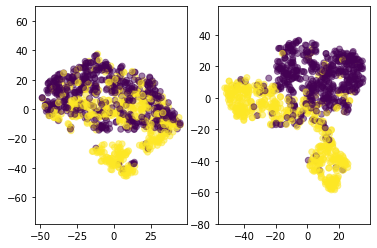

In [17]:
# write your code here
from sklearn.manifold import TSNE

x_train_small_np = x_train_small.cpu().numpy().reshape(-1, 28*28)
x_train_small_bottleneck_representation_np = x_train_small_bottleneck_representation.cpu().numpy().reshape(-1, 84)

plt.subplot(1, 2, 1)
tsne_original = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
x_train_small_tsne = tsne_original.fit_transform(x_train_small_np)
plt.scatter(x_train_small_tsne[:, 0],
            x_train_small_tsne[:, 1],
            c=y_train_small, alpha=0.5)
plt.axis('equal')

plt.subplot(1, 2, 2)
tsne_bottleneck = TSNE(n_components=2, verbose=1, perplexity=25, random_state=0)
x_train_small_bottleneck_representation_tsne = tsne_bottleneck.fit_transform(x_train_small_bottleneck_representation_np)
plt.scatter(x_train_small_bottleneck_representation_tsne[:, 0],
            x_train_small_bottleneck_representation_tsne[:, 1],
            c=y_train_small, alpha=0.5)
plt.axis('equal')

**(c) [16 points]** We now evaluate on test data and compare several different classifiers. Train **5-NN** and **random forest** classifiers with **784 (=28$\times$28) raw features** and, separately, the **84 bottleneck features** from **all training data**, respectively. That means you should train 4 models in total:

1. 5-NN classifier trained on all raw training features
2. 5-NN classifier trained on all training bottleneck features
3. Random forest trained on all raw training features (for reproducibility of code, please use arguments `n_estimators=100, random_state=0` for `RandomForestClassifier`)
4. Random forest trained on all training bottleneck features (again, use `n_estimators=100, random_state=0`)

Test each model with corresponding **test dataset** and print the test accuracy (raw accuracy and not some other score like weighted F1). Also, compute and print the test accuracy of the **pre-trained convnet** (`convnet`) by using **test data**. You may think of this task as filling in the blanks of the following table with test accuracy results.

| Model type       | Raw features        | Bottleneck features  |
|:---------------- |:-------------------:|:--------------------:|
| Pretrained CNN   |                0.891| this cell stays empty|
| 5-NN             |                0.856|                 0.888|
| Random forest    |               0.8765|                 0.898|

Important: the pre-trained convnet is for all 10 classes; only look at the probabilities corresponding to pullovers (class 2) and shirts (class 6), and take an argmax only over these two class probabilities to come up with predictions stricted to pullovers or shirts.

In [18]:
# write your code here
x_train_np = x_train.cpu().numpy().reshape(-1, 28*28)
y_train_np = y_train.cpu().numpy()
x_test_np = x_test.cpu().numpy().reshape(-1, 28*28)
y_test_np = y_test.cpu().numpy()

def print_result(name,r_acc,b_acc):
    print(name.ljust(15), str(r_acc).ljust(15), str(b_acc).ljust(15), flush=True)

print_result('', 'Raw features', 'Bottleneck features')

# Evaluate Pretrained CNN accuracy on x_test (raw features)
cnn_predictions = UDA_pytorch_model_transform(convnet, x_test)[:, [2, 6]].argmax(axis=1)
cnn_predictions_np = cnn_predictions.cpu().numpy()
cnn_accuracy = np.mean(cnn_predictions_np == y_test_np)
print_result('Pre-trained CNN', cnn_accuracy, '')
import copy

x_train_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_train)
x_test_bottleneck_representation = UDA_pytorch_model_transform(intermediate_layer_model, x_test)

x_train_bottleneck_representation_np = x_train_bottleneck_representation.cpu().numpy()
x_test_bottleneck_representation_np = x_test_bottleneck_representation.cpu().numpy()

names = ['5-NN', 'Random Forest']
clfs = [KNeighborsClassifier(5), RandomForestClassifier(n_estimators=100, random_state=0)]
for name, clf_using_raw_features, clf_using_bottleneck_features in zip(names, clfs, copy.deepcopy(clfs)):
    # train models with raw features and bottleneck features repectively
    # train and test with raw features
    clf_using_raw_features.fit(x_train_np, y_train_np)
    accuracy_using_raw_features = clf_using_raw_features.score(x_test_np, y_test_np)
    
    # train and test with bottleneck features
    clf_using_bottleneck_features.fit(x_train_bottleneck_representation_np, y_train_np)
    accuracy_using_bottleneck_features = \
        clf_using_bottleneck_features.score(x_test_bottleneck_representation_np, y_test_np)
    
    print_result(name, accuracy_using_raw_features, accuracy_using_bottleneck_features)

                Raw features    Bottleneck features
Pre-trained CNN 0.891                          
5-NN            0.856           0.888          
Random Forest   0.8765          0.898          


Among the five models above, which model performed the best? Which model showed the lowest accuracy? For the 5-NN and random forest classifiers, is the prediction accuracy higher using bottleneck features instead of the raw features?

**Write your answers here:** The random forest with bottleneck features has the highest accuracy. 5-NN with raw features has the lowest accuracy. For both 5-NN and random forest classifiers, using bottleneck features results in a noticeable boost in accuracy.

Note that in general, the neural net might not actually achieve the best accuracy. The last layer is just doing multinomial logistic regression, which could fare worse than a more clever final classifier that uses the same bottleneck features.

**(d) [10 points]** We now look at plotting an ROC curve, varying $k$ in $k$-NN. Train k-NN classifiers with $k=1,2,...,50$ with **bottleneck** feature vectors of all **training** data. As a result, you will get 50 classifiers. Draw a scatter plot that has false positive rate (FPR) on x-axis and true positive rate (TPR) on y-axis. Each scatter point represents one k-NN classifier. Use the **test** data to compute FPR and TPR.

Recall that true and false positive rate calculations require you to specify one of the two outcomes as the "positive" class and the other as the "negative" class. For this problem, use class 6 (shirts) as the "positive" class, and class 2 (pullovers) as the "negative" class.

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50


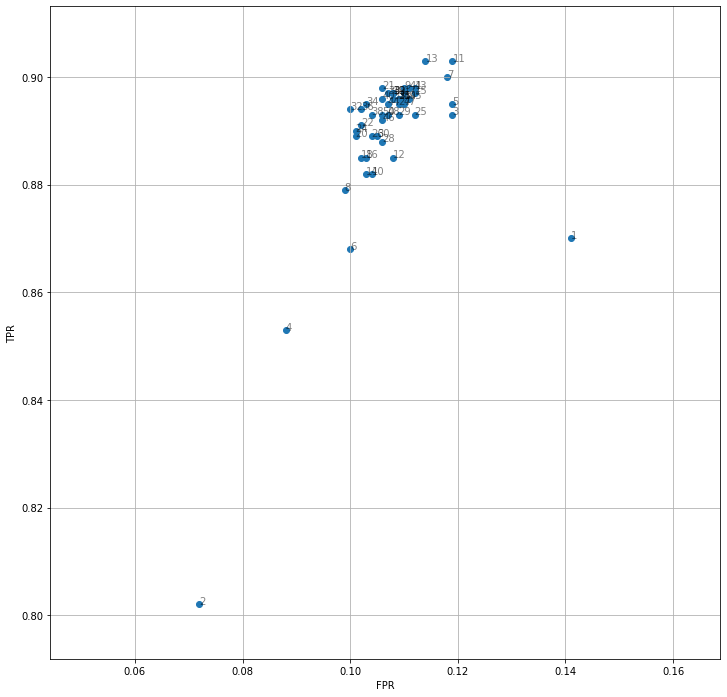

In [19]:
# write your code here
FPR_list = []
TPR_list = []
k_list = np.arange(1, 51)

for k in k_list:
    print(k)
    
    clf = KNeighborsClassifier(k)
    clf.fit(x_train_bottleneck_representation_np, y_train_np)
    predicted_y_test = clf.predict(x_test_bottleneck_representation_np)
    
    true_neg_mask = (y_test_np == 0)
    FPR = (predicted_y_test[true_neg_mask] == 1).sum() / true_neg_mask.sum()
    
    true_pos_mask = (y_test_np == 1)
    TPR = (predicted_y_test[true_pos_mask] == 1).sum() / true_pos_mask.sum()
    
    FPR_list.append(FPR)
    TPR_list.append(TPR)

plt.figure(figsize=(12, 12))
plt.scatter(FPR_list, TPR_list)
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.grid()
plt.axis('equal')

for k, FPR, TPR in zip(k_list, FPR_list, TPR_list):
    plt.text(FPR, TPR, k, alpha=0.5)

Suppose you work for a company that wants to figure out when a shirt appears among photos that have either shirts or pullovers. The company tells you that it cannot tolerate a false positive rate of detecting shirts that is more than 12.5%. What value of number of nearest neighbors $k$ achieves the highest true positive rate, but doesn't have more than a 12.5% false positive rate?

**Write your answer here:** We look at which choice of $k$ yields as high of a true positive rate as possible while maintaining a false positive rate at most 12.5%; by eyeballing the plot above, it looks like $k=11$ or $k=13$ are both good choices and achieve similar true positive rate values.

# Part 3: Sentiment Analysis [40 points]

Download data from: http://www.andrew.cmu.edu/user/georgech/HW3-data.zip <br>

The folder contains:

- `train.csv`
- `test.csv`

In this problem, we look at predicting whether a tweet has positive or negative sentiment. We intentionally write this problem to be a bit open-ended to let you play with different neural net code yourself and also for you to compare against a classical baseline.

**(a) [5 points]** We first read in the tweet data. Read the data present in `train.csv` file. **Please do not change the filename. In particular, use a relative path, i.e., `./HW3-data/train.csv`**. Then do the following:

1. Keep only the sentiment and sentiment text in the data - the first and the last coumn
2. Print the number of positive and negative sentiment labels

Note: If you are using `open()`, you may have to set `encoding='iso8859'`.

In [20]:
import numpy as np
import torch
import torch.nn as nn

%matplotlib inline
import matplotlib.pyplot as plt

In [21]:
# your code here
import csv
def load_csv(csv_filename):
    labels = []
    tweets = []
    with open(csv_filename, encoding='iso8859') as f:
        csv_reader = csv.reader(f)
        for row in csv_reader:
            labels.append(int(row[0]))
            tweets.append(row[-1])
    return tweets, np.array(labels)

train_text, train_labels = load_csv('HW3-data/train.csv')
print('Number of positive labels:', (train_labels == 1).sum())
print('Number of negative labels:', (train_labels == 0).sum())

Number of positive labels: 800000
Number of negative labels: 800000


**(b) [25 points]** Modify the LSTM demo code from lecture to work with this Twitter dataset. Play with the learning rate and batch size so that the training gives reasonable increases in training and validation accuracies as we progress through epochs (leave the number of epochs at 10). Also feel free to try different neural net architectures (although you do not have to). What test accuracy are you able to achieve?

In [22]:
# your code here
train_dataset = list(zip(train_text, train_labels))

proper_train_size = int(len(train_dataset) * 0.8)
val_size = len(train_dataset) - proper_train_size

torch.manual_seed(0)
proper_train_dataset, val_dataset = torch.utils.data.random_split(train_dataset,
                                                                  [proper_train_size,
                                                                   val_size])

In [23]:
import spacy
spacy.require_gpu()
from collections import Counter

# there are many ways to preprocess the data; this is just one way
nlp = spacy.load('en_core_web_sm', disable=['ner', 'tagger', 'parser'])
proper_train_tweets = [tweet for tweet, label in proper_train_dataset]
histogram = Counter()
for idx, doc in enumerate(nlp.pipe(proper_train_tweets)):
    if (idx + 1) % 10000 == 0:
        print('Parsing tweet %d/%d, dictionary size: %d' % (idx + 1, proper_train_size, len(histogram)))
    for token in doc:
        lemma = token.lemma_.lower()
        if not (len(lemma.strip()) == 0 \
                or token.pos_ == 'SPACE'):
            histogram[lemma] += 1

vocab_size = 2000
vocab = ['<pad>', '<unk>'] \
    + sorted([word for word, count in histogram.most_common()[:(vocab_size-2)]])
vocab_to_idx = {word: idx for idx, word in enumerate(vocab)}
print('Vocabulary size:', vocab_size)

Parsing tweet 10000/1280000, dictionary size: 18070
Parsing tweet 20000/1280000, dictionary size: 30016
Parsing tweet 30000/1280000, dictionary size: 40690
Parsing tweet 40000/1280000, dictionary size: 50442
Parsing tweet 50000/1280000, dictionary size: 59643
Parsing tweet 60000/1280000, dictionary size: 68236
Parsing tweet 70000/1280000, dictionary size: 76487
Parsing tweet 80000/1280000, dictionary size: 84484
Parsing tweet 90000/1280000, dictionary size: 92350
Parsing tweet 100000/1280000, dictionary size: 100059
Parsing tweet 110000/1280000, dictionary size: 107685
Parsing tweet 120000/1280000, dictionary size: 115073
Parsing tweet 130000/1280000, dictionary size: 122191
Parsing tweet 140000/1280000, dictionary size: 129093
Parsing tweet 150000/1280000, dictionary size: 135849
Parsing tweet 160000/1280000, dictionary size: 142701
Parsing tweet 170000/1280000, dictionary size: 149362
Parsing tweet 180000/1280000, dictionary size: 155947
Parsing tweet 190000/1280000, dictionary size:

In [24]:
def encode_tweets(tweets):
    n = len(tweets)
    all_encoded = []
    for idx, doc in enumerate(nlp.pipe(tweets)):
        encoded = []
        if (idx + 1) % 10000 == 0:
            print('Parsing tweet %d/%d' % (idx + 1, n))
        for token in doc:
            lemma = token.lemma_.lower()
            if not (len(lemma.strip()) == 0 \
                    or token.pos_ == 'SPACE'):
                if lemma in vocab_to_idx:
                    encoded.append(vocab_to_idx[lemma])
                else:
                    encoded.append(vocab_to_idx['<unk>'])
        all_encoded.append(torch.tensor(encoded, dtype=torch.long))
    return all_encoded

In [25]:
proper_train_encoded = encode_tweets(proper_train_tweets)
proper_train_labels = torch.tensor([label for tweet, label in proper_train_dataset], dtype=torch.long)

Parsing tweet 10000/1280000
Parsing tweet 20000/1280000
Parsing tweet 30000/1280000
Parsing tweet 40000/1280000
Parsing tweet 50000/1280000
Parsing tweet 60000/1280000
Parsing tweet 70000/1280000
Parsing tweet 80000/1280000
Parsing tweet 90000/1280000
Parsing tweet 100000/1280000
Parsing tweet 110000/1280000
Parsing tweet 120000/1280000
Parsing tweet 130000/1280000
Parsing tweet 140000/1280000
Parsing tweet 150000/1280000
Parsing tweet 160000/1280000
Parsing tweet 170000/1280000
Parsing tweet 180000/1280000
Parsing tweet 190000/1280000
Parsing tweet 200000/1280000
Parsing tweet 210000/1280000
Parsing tweet 220000/1280000
Parsing tweet 230000/1280000
Parsing tweet 240000/1280000
Parsing tweet 250000/1280000
Parsing tweet 260000/1280000
Parsing tweet 270000/1280000
Parsing tweet 280000/1280000
Parsing tweet 290000/1280000
Parsing tweet 300000/1280000
Parsing tweet 310000/1280000
Parsing tweet 320000/1280000
Parsing tweet 330000/1280000
Parsing tweet 340000/1280000
Parsing tweet 350000/12

In [26]:
val_encoded = encode_tweets([tweet for tweet, label in val_dataset])
val_labels = torch.tensor([label for tweet, label in val_dataset], dtype=torch.long)

Parsing tweet 10000/320000
Parsing tweet 20000/320000
Parsing tweet 30000/320000
Parsing tweet 40000/320000
Parsing tweet 50000/320000
Parsing tweet 60000/320000
Parsing tweet 70000/320000
Parsing tweet 80000/320000
Parsing tweet 90000/320000
Parsing tweet 100000/320000
Parsing tweet 110000/320000
Parsing tweet 120000/320000
Parsing tweet 130000/320000
Parsing tweet 140000/320000
Parsing tweet 150000/320000
Parsing tweet 160000/320000
Parsing tweet 170000/320000
Parsing tweet 180000/320000
Parsing tweet 190000/320000
Parsing tweet 200000/320000
Parsing tweet 210000/320000
Parsing tweet 220000/320000
Parsing tweet 230000/320000
Parsing tweet 240000/320000
Parsing tweet 250000/320000
Parsing tweet 260000/320000
Parsing tweet 270000/320000
Parsing tweet 280000/320000
Parsing tweet 290000/320000
Parsing tweet 300000/320000
Parsing tweet 310000/320000
Parsing tweet 320000/320000


In [27]:
from torchnlp.word_to_vector import GloVe
pretrained_embedding = GloVe(name='6B', dim=100)

embedding_weights = torch.Tensor(vocab_size, pretrained_embedding.dim)
for i, word in enumerate(vocab):
    embedding_weights[i] = pretrained_embedding[word]

In [28]:
proper_train_dataset_encoded = list(zip(proper_train_encoded, proper_train_labels))
val_dataset_encoded = list(zip(val_encoded, val_labels))

Epoch 1 [==================================================] 1280000/1280000
  Train accuracy: 0.7790
  Validation accuracy: 0.7760
Epoch 2 [==================================================] 1280000/1280000
  Train accuracy: 0.8053
  Validation accuracy: 0.8014
Epoch 3 [==================================================] 1280000/1280000
  Train accuracy: 0.7994
  Validation accuracy: 0.7945
Epoch 4 [==================================================] 1280000/1280000
  Train accuracy: 0.8050
  Validation accuracy: 0.7995
Epoch 5 [==================================================] 1280000/1280000
  Train accuracy: 0.8012
  Validation accuracy: 0.7949
Epoch 6 [==================================================] 1280000/1280000
  Train accuracy: 0.8131
  Validation accuracy: 0.8065
Epoch 7 [==================================================] 1280000/1280000
  Train accuracy: 0.8149
  Validation accuracy: 0.8085
Epoch 8 [==================================================] 1280000/1280000

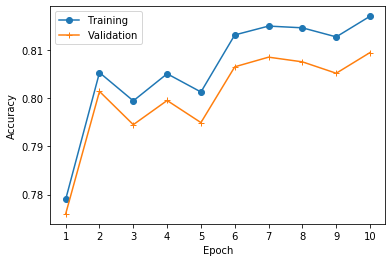

In [29]:
from UDA_pytorch_utils import UDA_LSTMforSequential, UDA_pytorch_classifier_fit, \
    UDA_plot_train_val_accuracy_vs_epoch, UDA_pytorch_classifier_predict, \
    UDA_compute_accuracy

simple_lstm_model = nn.Sequential(nn.Embedding.from_pretrained(embedding_weights),
                                  UDA_LSTMforSequential(100, 64),
                                  nn.Linear(64, 2))

num_epochs = 10  # during optimization, how many times we look at training data
batch_size = 512  # during optimization, how many training data to use at each step
learning_rate = 0.01  # during optimization, how much we nudge our solution at each step

train_accuracies, val_accuracies = \
    UDA_pytorch_classifier_fit(simple_lstm_model,
                               torch.optim.AdamW(simple_lstm_model.parameters(),
                                                 lr=learning_rate),
                               nn.CrossEntropyLoss(),  # includes softmax
                               proper_train_dataset_encoded, val_dataset_encoded,
                               num_epochs, batch_size,
                               sequence=True)

UDA_plot_train_val_accuracy_vs_epoch(train_accuracies, val_accuracies)

In [30]:
test_tweets, test_labels = load_csv('HW3-data/test.csv')
test_dataset = list(zip(test_tweets, test_labels))
test_encoded = encode_tweets([tweet for tweet, label in test_dataset])
test_labels = torch.tensor([label for tweet, label in test_dataset], dtype=torch.long)

predicted_test_labels = UDA_pytorch_classifier_predict(simple_lstm_model,
                                                       test_encoded,
                                                       sequence=True)

print('Test accuracy:', UDA_compute_accuracy(predicted_test_labels, test_labels))

Test accuracy: 0.6325301204819277


**(c) [10 points]** How well does an LSTM compare with using a classical classifier? To investigate this question, let's try training a random forest for sentiment analysis. Your code from part **(b)** should involve coming up with encoded representations of text, i.e., representing a tweet using a sequence of word indices. Use this to come up with a term frequency representation for each tweet. Feel free to remove stop words and/or apply TF-IDF weighting, and then feed the resulting feature vector representations for tweets to a random forest classifier. You can use cross-validation to select hyperparameters. Try to make the random forest classifier perform as well as possible (it is good practice in real-world applications to try to make baselines as good as possible rather than intentionally using a baseline with lousy hyperparameter choices; in particular, it is *bad* practice to tune hyperparameters carefully only on a method you're proposing while not tuning hyperparameters on baselines!). What test set accuracy are you able to achieve with the random forest?

In [31]:
# your code here
from multiprocessing import Pool

def bag_of_words_encode_tweet(args):
    tweet, vocab_size = args
    feature_vector = np.zeros(vocab_size)
    for word_idx in tweet:
        feature_vector[word_idx] += 1
    return feature_vector

def bag_of_words_encode(already_encoded_tweets):
    p = Pool()
    feature_vectors = p.map(bag_of_words_encode_tweet,
                            [(encoded.cpu().numpy(), vocab_size)
                             for encoded in already_encoded_tweets])
    p.close()
    return feature_vectors

baseline_proper_train_encoded = bag_of_words_encode(proper_train_encoded)
baseline_proper_train_labels = [label for tweet, label in proper_train_dataset]
baseline_val_encoded = bag_of_words_encode(val_encoded)
baseline_val_labels = [label for tweet, label in val_dataset]

In [32]:
from scipy.sparse import csc_matrix

baseline_proper_train_encoded_sparse = csc_matrix(baseline_proper_train_encoded)
baseline_val_encoded_sparse = csc_matrix(baseline_val_encoded)

In [33]:
num_features = vocab_size
hyperparameter_settings = [(max_features, min_samples_leaf)
                           for max_features in [int(np.sqrt(num_features) / 4),
                                                int(np.sqrt(num_features) / 2),
                                                int(np.sqrt(num_features)),
                                                int(np.sqrt(num_features) * 2),
                                                int(np.sqrt(num_features) * 4)]
                           for min_samples_leaf in [1]]
best_val_score = -np.inf  # assumes that a higher score is better
best_model = None

for hyperparam_setting in hyperparameter_settings:
    # your code to train and score the training data here
    max_features, min_samples_leaf = hyperparam_setting
    
    clf = RandomForestClassifier(max_features=max_features,
                                 min_samples_leaf=min_samples_leaf,
                                 random_state=0, verbose=1, n_jobs=-1,
                                 max_samples=0.1)
    clf.fit(baseline_proper_train_encoded_sparse,
            baseline_proper_train_labels)
    
    predicted_val_labels = clf.predict(baseline_val_encoded_sparse)
    val_score = np.mean(baseline_val_labels == predicted_val_labels)
    
    print(hyperparam_setting, ':', val_score)
    if val_score > best_val_score:  # assumes that a higher score is better
        best_val_score = val_score
        best_hyperparam_setting = hyperparam_setting
        best_model = clf

print('Best hyperparameter setting:', best_hyperparam_setting)
# best_max_features, best_min_samples_leaf = best_hyperparam_setting

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  4.0min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.5s finished


(11, 1) : 0.778803125


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  5.0min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.3s finished


(22, 1) : 0.77644375


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  6.6min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    1.1s finished


(44, 1) : 0.7723


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  9.8min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.9s finished


(89, 1) : 0.76830625


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 36 concurrent workers.
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 15.7min finished
[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.


(178, 1) : 0.7654125
Best hyperparameter setting: (11, 1)


[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.8s finished


In [34]:
baseline_test_encoded_sparse = csc_matrix(bag_of_words_encode(test_encoded))

baseline_predicted_test_labels = best_model.predict(baseline_test_encoded_sparse)
print('Test accuracy:', np.mean(baseline_predicted_test_labels == test_labels.cpu().numpy()))

[Parallel(n_jobs=36)]: Using backend ThreadingBackend with 36 concurrent workers.


Test accuracy: 0.606425702811245


[Parallel(n_jobs=36)]: Done 100 out of 100 | elapsed:    0.2s finished
